In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
CSV_1 = '/kaggle/input/heartbeat/mitbih_train.csv'
CSV_2 = '/kaggle/input/heartbeat/mitbih_test.csv'

mit_train = pd.read_csv(CSV_1, header=None)
mit_test = pd.read_csv(CSV_2, header=None)

In [6]:
mit_train[187] = mit_train[187].astype('int64')

mit_test[187] = mit_test[187].astype('int64')

In [7]:
from imblearn.over_sampling import RandomOverSampler

data = mit_train.iloc[:, :187]
labels = mit_train.iloc[:, 187]

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Resample the data
data_resampled, labels_resampled = ros.fit_resample(data, labels)

train_df = pd.concat([data_resampled, labels_resampled], axis=1)

In [8]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_df.iloc[:, :187],
                                                train_df.iloc[:, 187],
                                                test_size= 0.2,
                                                stratify=train_df.iloc[:, 187],
                                                random_state=42)

x_test = mit_test.iloc[:, :187]
y_test = mit_test.iloc[:, 187]

In [9]:
x_train = x_train.values
x_val = x_val.values
x_test = x_test.values

In [10]:
x_train = x_train.reshape(x_train.shape[0], -1, 1)
x_val = x_val.reshape(x_val.shape[0], -1, 1)
x_test = x_test.reshape(x_test.shape[0], -1, 1)

In [11]:
import tensorflow as tf

# Converts a class vector (integers) to binary class matrix (one hot encoder).

y_train = tf.keras.utils.to_categorical(y_train)

y_val = tf.keras.utils.to_categorical(y_val)

y_test = tf.keras.utils.to_categorical(y_test)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, MaxPool1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, kernel_size=1, stride=1):
    # Shortcut connection
    shortcut = x
    
    # If the number of filters changes, adjust the shortcut
    if x.shape[-1] != filters:
        shortcut = layers.Conv1D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)
    
    # First convolution layer
    x = layers.Conv1D(filters, kernel_size, strides=stride, padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    
    # Second convolution layer
    x = layers.Conv1D(filters, kernel_size, strides=1, padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    
    # Add shortcut (residual connection)
    x = layers.add([x, shortcut])
    x = layers.ReLU()(x)
    
    return x

# ResNet with BiLSTM model
def build_resnet_bilstm(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial convolution layer
    x = layers.Conv1D(filters=151, kernel_size=1, strides=1, padding='same', activation='relu')(inputs)
    x = layers.MaxPool1D(pool_size=2, strides=2)(x)

    # Residual blocks instead of stacked Conv1D layers
    x = residual_block(x, 151)  
    x = layers.MaxPool1D(pool_size=2, strides=2)(x)  
    
    x = residual_block(x, 101)  
    x = layers.MaxPool1D(pool_size=2, strides=2)(x)
    
    x = residual_block(x, 51)  
    x = layers.MaxPool1D(pool_size=2, strides=2)(x)
    
    # LSTM layers (BiLSTM)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, activation='tanh'))(x)
    x = layers.Bidirectional(layers.LSTM(32, activation='tanh'))(x)

    # Flatten the output before Dense layers
    x = layers.Flatten()(x)
    
    # Fully connected layers
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dense(32, activation='relu')(x)
    
    # Output layer with softmax activation (for classification)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs)
    
    return model

In [14]:
input_shape = (x_train.shape[1:])  # Use the same input shape as your data
num_classes = 5  # Number of classes

model_resnet_bilstm = build_resnet_bilstm(input_shape, num_classes)

# Compile the model
model_resnet_bilstm.compile(optimizer='adam',
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

# Print the model summary
model_resnet_bilstm.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 151)  │        302 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 93, 151)   │          0 │ conv1d[0][0]      │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 93, 151)   │     22,952 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 93, 151)   │        604 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 93, 151)   │     22,952 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 151)   │        604 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 93, 151)   │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 93, 151)   │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 46, 151)   │          0 │ re_lu[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 46, 101)   │     15,352 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 101)   │        404 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 46, 101)   │     10,302 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 46, 101)   │     15,352 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 101)   │        404 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 101)   │        404 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 46, 101)   │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 46, 101)   │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_2     │ (None, 23, 101)   │          0 │ re_lu_1[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 210,313 (821.54 KB)

 Trainable params: 208,797 (815.61 KB)

 Non-trainable params: 1,516 (5.92 KB)

In [18]:
callbacks = [EarlyStopping(monitor='val_loss', 
                           patience=8),
             ReduceLROnPlateau(patience=20,
                               monitor='val_loss',
                               min_lr=1e-6,
                               cool_down=20),
             ModelCheckpoint(filepath='best_model_cnn_bilstm.keras', 
                             monitor='val_loss',
                             save_best_only=True)]

In [19]:
history = model_resnet_bilstm.fit(x_train, y_train, 
                        epochs=10, 
                        callbacks=callbacks, 
                        batch_size=32, 
                        validation_data=(x_val, y_val),
                       verbose=1)

Epoch 1/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 491s 53ms/step - accuracy: 0.8725 - loss: 0.3460 - val_accuracy: 0.9540 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 2/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 472s 52ms/step - accuracy: 0.9707 - loss: 0.0843 - val_accuracy: 0.9736 - val_loss: 0.0782 - learning_rate: 0.0010
Epoch 3/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 470s 52ms/step - accuracy: 0.9823 - loss: 0.0519 - val_accuracy: 0.9837 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 4/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 471s 52ms/step - accuracy: 0.9875 - loss: 0.0380 - val_accuracy: 0.9872 - val_loss: 0.0378 - learning_rate: 0.0010
Epoch 5/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 475s 52ms/step - accuracy: 0.9903 - loss: 0.0300 - val_accuracy: 0.9760 - val_loss: 0.0811 - learning_rate: 0.0010
Epoch 6/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 479s 53ms/step - accuracy: 0.9916 - loss: 0.0264 - val_accuracy: 0.9920 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 7/10
9059/9059 ━━━━━━━━━━━━━━━━━━━━ 480s 53ms/step -

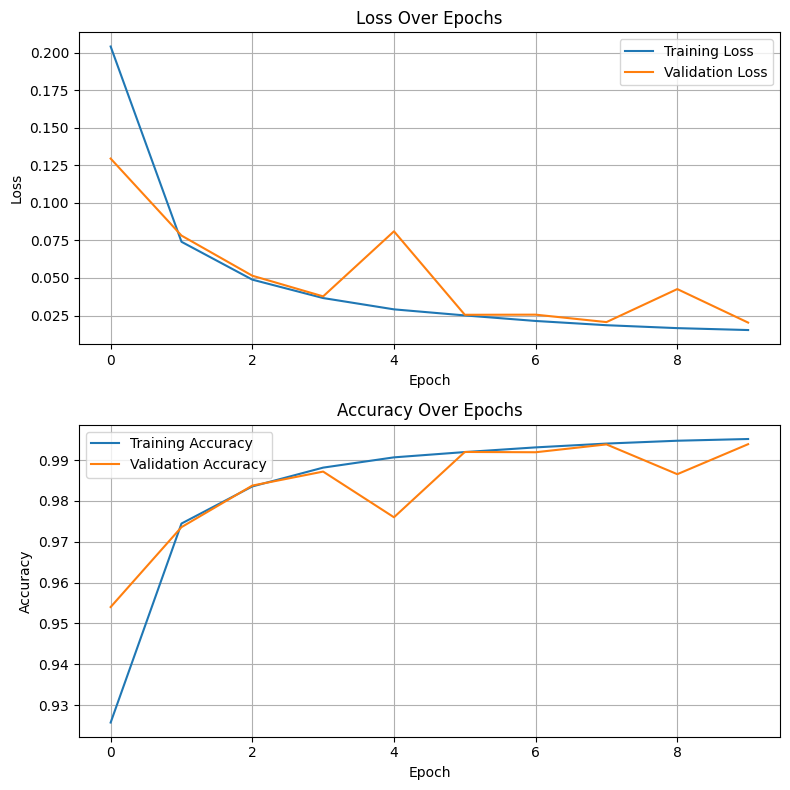

In [20]:
fig, axs = plt.subplots(2, figsize=(8, 8))

# Plot loss
axs[0].plot(history.history['loss'], label='Training Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].set_title('Loss Over Epochs')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].grid(True)

# Plot accuracy
axs[1].plot(history.history['accuracy'], label='Training Accuracy')
axs[1].plot(history.history['val_accuracy'], label='Validation Accuracy')
axs[1].set_title('Accuracy Over Epochs')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [21]:
train_score = model_resnet_bilstm.evaluate(x_train, y_train)
validation_score = model_resnet_bilstm.evaluate(x_val, y_val)

print('Accuracy Train data: ', train_score[1])
print('Accuracy Validation data: ', validation_score[1])

9059/9059 ━━━━━━━━━━━━━━━━━━━━ 127s 14ms/step - accuracy: 0.9964 - loss: 0.0107
2265/2265 ━━━━━━━━━━━━━━━━━━━━ 32s 14ms/step - accuracy: 0.9937 - loss: 0.0210
Accuracy Train data:  0.9962640404701233
Accuracy Validation data:  0.9938734173774719


In [22]:
y_pred = model_resnet_bilstm.predict(x_test)

685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step


In [23]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels to integer labels
y_test_labels = np.argmax(y_test, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

print(classification_report(y_test_labels, y_pred_labels))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     18118
           1       0.74      0.81      0.77       556
           2       0.92      0.94      0.93      1448
           3       0.59      0.81      0.68       162
           4       0.98      0.98      0.98      1608

    accuracy                           0.97     21892
   macro avg       0.84      0.90      0.87     21892
weighted avg       0.98      0.97      0.97     21892



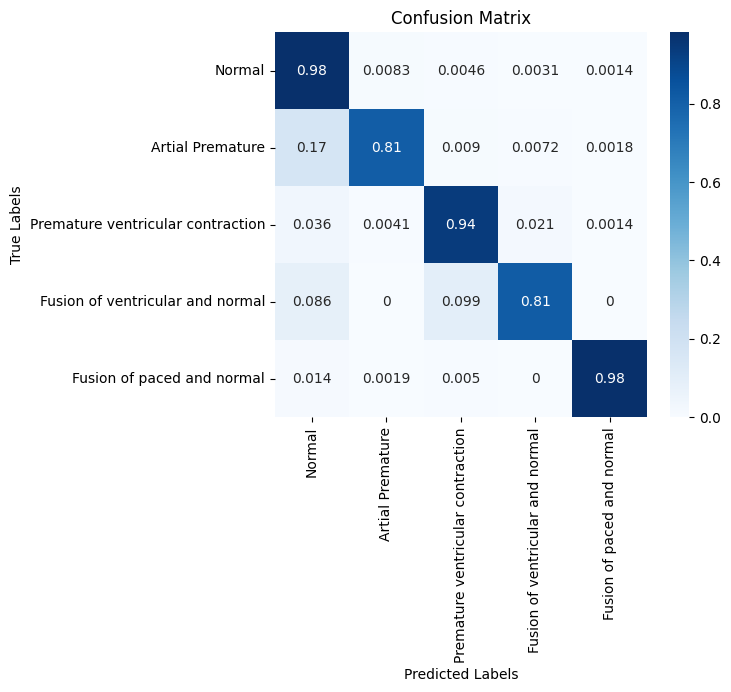

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calculate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels, 
                      normalize='true')

labels = ['Normal', 'Artial Premature', 'Premature ventricular contraction', 'Fusion of ventricular and normal', 'Fusion of paced and normal']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from tensorflow.keras.models import save_model

# Save the model
model_resnet_bilstm.save('resnet_model.keras')